# Goal

* Initial testing, assessment, and debugging of SIPSim qSIP data
* **Parameters**
  * 12C control & 13C treatment gradients
  * n replicate gradients = 3 (n-total = 6)
  * n technical replicate qPCRs (per sample) = 3
  * % atom excess = 100%
  * % taxa with incorporation = 10%

# Init

In [381]:
import os
import glob
import re
import nestly
%load_ext rpy2.ipython
%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [382]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

# Nestly

* assuming fragments already simulated

In [383]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/'
buildDir = os.path.join(workDir, 'default_rep3')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags.pkl'
genomeIndex = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/genome_index.txt'

# simulation parameters
prefrac_comm_abundance = '1e9'
n_gradient_reps = 3
nprocs = 24

In [390]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('abs', [prefrac_comm_abundance])

## set params
nest.add('percIncorp', [100], create_dir=False)       # percent atom excess 
nest.add('percTaxa', [0], create_dir=False)           # overidden by 'nIncorporators'
nest.add('nIncorporators', [114], create_dir=False)   # number of incorporators
nest.add('n_gradient_reps', [n_gradient_reps], create_dir=False)
nest.add('np', [nprocs], create_dir=False)


### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('genomeIndex', [genomeIndex], create_dir=False)

# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [391]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

echo '#-- SIPSim pipeline --#'
echo '# converting fragments to KDE'
SIPSim fragment_KDE \
    {fragFile} \
    > ampFrags_KDE.pkl
    
echo '# adding diffusion'    
SIPSim diffusion \
    ampFrags_KDE.pkl \
    --np {np} \
    > ampFrags_KDE_dif.pkl    

echo '# adding DBL contamination'
SIPSim DBL \
    ampFrags_KDE_dif.pkl \
    --np {np} \
    > ampFrags_KDE_dif_DBL.pkl      
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  --n_reps 3 \
  > {percTaxa}_{percIncorp}_{n_gradient_reps}.config

echo '# selecting incorporator taxa (over-riding percTaxa)'
echo '## this is to make the gradient replicates consistent (qSIP finds mean among replicates)'
SIPSim KDE_selectTaxa \
    ampFrags_KDE_dif_DBL.pkl \
    -s {nIncorporators} > incorporators.txt

echo '# making community file'
SIPSim communities \
    --config {percTaxa}_{percIncorp}_{n_gradient_reps}.config \
    {genomeIndex} \
    > comm.txt    

echo '# adding isotope incorporation to BD distribution'
echo '## same incorporators for each treatment gradient'
SIPSim isotope_incorp \
    ampFrags_KDE_dif_DBL.pkl \
    {percTaxa}_{percIncorp}_{n_gradient_reps}.config \
    --comm comm.txt \
    --taxa incorporators.txt \
    --np {np} \
    > ampFrags_KDE_dif_DBL_inc.pkl
    
echo '# calculating BD shift from isotope incorporation'
SIPSim BD_shift \
    ampFrags_KDE_dif_DBL.pkl \
    ampFrags_KDE_dif_DBL_inc.pkl \
    --np {np} \
    > ampFrags_KDE_dif_DBL_inc_BD-shift.pkl

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    comm.txt > fracs.txt 

echo '# simulating an OTU table'
SIPSim OTU_table \
    ampFrags_KDE_dif_DBL_inc.pkl \
    comm.txt \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
echo '# simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt
    
    
echo '# Removing control.json file'    
rm -f control.json

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/SIPSimRun.sh


In [392]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d default_rep3 --log-file log.txt -j 1

2016-01-24 14:29:52,834 * INFO * Template: ./SIPSimRun.sh
2016-01-24 14:29:52,840 * INFO * [209059] Started ./SIPSimRun.sh in default_rep3/1e9
2016-01-24 15:17:28,433 * INFO * [209059] default_rep3/1e9 Finished with 0


# qSIP

In [398]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('abs', [prefrac_comm_abundance])
nest.add('sim_rep', range(10))

# constant params
expDesignFile = os.path.join(buildDir, 'exp_design.txt')
nest.add('expDesignFile', [expDesignFile], create_dir=False)
nest.add('buildDir', [buildDir], create_dir=False)

# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'qSIPRun.sh')

In [399]:
%%writefile $expDesignFile

1	control
2	treatment
3	control
4	treatment
5	control
6	treatment

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/exp_design.txt


In [400]:
%%writefile $bashFile
#!/bin/bash

# qSIP
SIPSim qSIP \
    --reps 3 \
    {buildDir}/{abs}/OTU_abs1e9.txt {buildDir}/{abs}/OTU_abs1e9_PCR_sub.txt \
    > OTU_abs1e9_PCR_sub_qSIP.txt
        
# atom excess
SIPSim qSIP_atomExcess \
    OTU_abs1e9_PCR_sub_qSIP.txt \
    {expDesignFile} \
    --np 14 \
    > OTU_abs1e9_PCR_sub_qSIP_atom.txt 

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/qSIPRun.sh


In [ ]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d default_rep3 --log-file log.txt -j 2

2016-01-24 15:27:57,146 * INFO * Template: ./qSIPRun.sh
2016-01-24 15:27:57,150 * INFO * [209677] Started ./qSIPRun.sh in default_rep3/1e9/7
2016-01-24 15:27:57,152 * INFO * [209679] Started ./qSIPRun.sh in default_rep3/1e9/0


# Analyzing the results

## Plotting total abs abundance (from OTU table)

In [403]:
%%R -i buildDir -i prefrac_comm_abundance 

OTU_file = file.path(buildDir, prefrac_comm_abundance, 'OTU_abs1e9.txt')

df.OTU = read.delim(OTU_file, sep='\t') %>%
    group_by(library, fraction, BD_mid) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = library %>% as.character) 

df.OTU %>% head(n=3)

Source: local data frame [3 x 4]

  library    fraction BD_mid total_count
    (chr)      (fctr)  (dbl)       (int)
1       1 1.660-1.662  1.661       70336
2       1 1.662-1.667  1.664      174453
3       1 1.667-1.671  1.669      146811


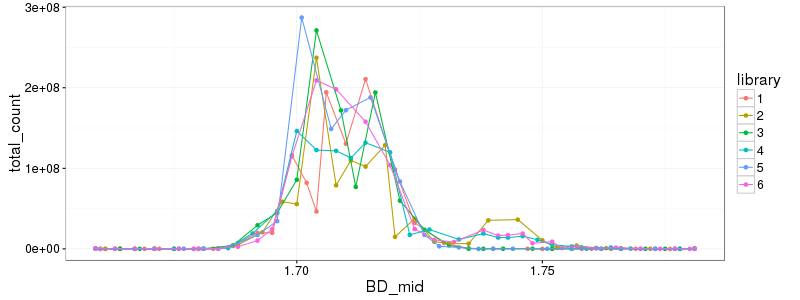

In [404]:
%%R -w 800 -h 300

ggplot(df.OTU, aes(BD_mid, total_count, color=library)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## qPCR values

In [405]:
qPCR_files = !find $buildDir -maxdepth 3 -name "OTU_abs1e9_PCR_sub_qSIP.txt"
qPCR_files

['/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/7/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/0/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/9/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/8/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/3/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/2/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/1/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/4/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/5/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/6/OTU_abs1e9

In [406]:
%%R -i qPCR_files
# loading files
df = list()
for (x in qPCR_files){
    f = gsub('/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/([0-9.]+)/.+', '\\1', x)
    df[[f]] = read.delim(x, sep='\t') %>%
        distinct(library, fraction) %>%
        select(-taxon) %>%
        as.data.frame()
    }
df = do.call('rbind', df)
df$file = gsub('\\.[0-9]+$', '', rownames(df))
rownames(df) = 1:nrow(df)
df = df %>%
    mutate(exp_design = ifelse(library %% 2 == 0, 'treatment', 'control'),
           library = library %>% as.character,
           file = file %>% as.numeric)
df %>% head(n=3)

  library   fraction BD_min BD_mid BD_max count    rel_abund total_qPCR_copies
1       1 -inf-1.660   -Inf  1.659  1.659     7 0.0007069279            517264
2       2 -inf-1.660   -Inf  1.659  1.659    30 0.0010806527            329721
3       3 -inf-1.660   -Inf  1.659  1.659    25 0.0010916077                 0
  prop_abs_abund file exp_design
1            366    7    control
2              0    7  treatment
3              0    7    control


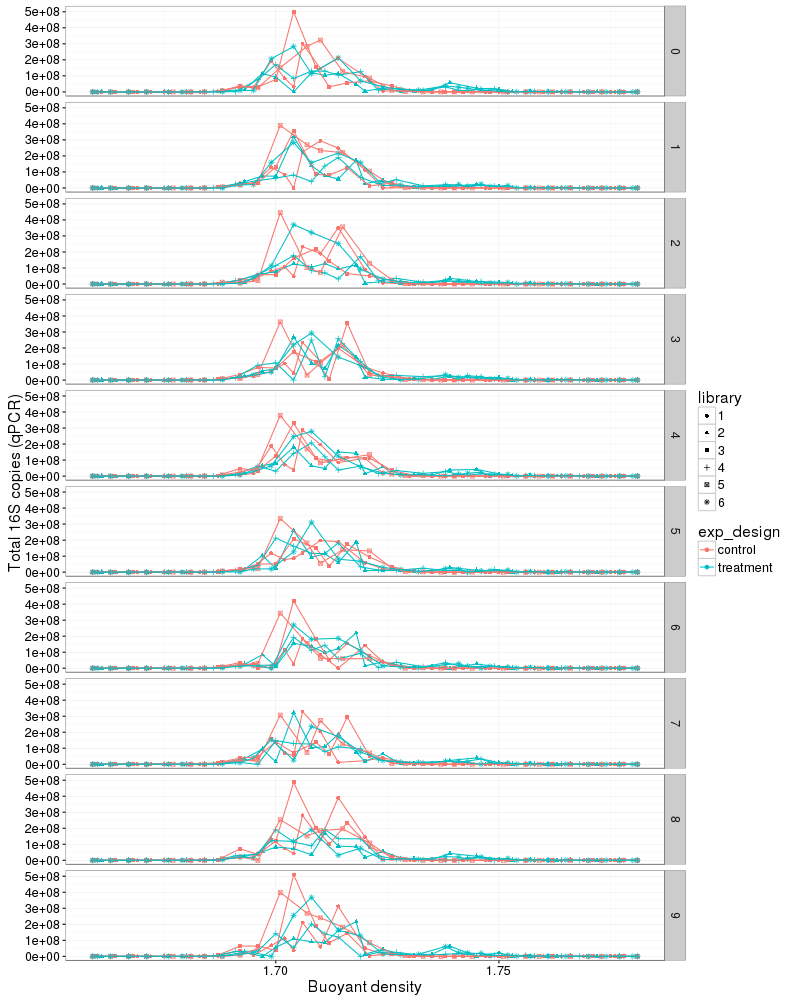

In [407]:
%%R -w 800 -h 1000

ggplot(df, aes(BD_mid, total_qPCR_copies, color=exp_design, group=library, shape=library)) +
    geom_point() +
    geom_line() +
    facet_grid(file ~ .) +
    #scale_y_log10() +
    labs(x = 'Buoyant density', y='Total 16S copies (qPCR)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Scaling to proportion of total (as in Hungate et al., 2015)

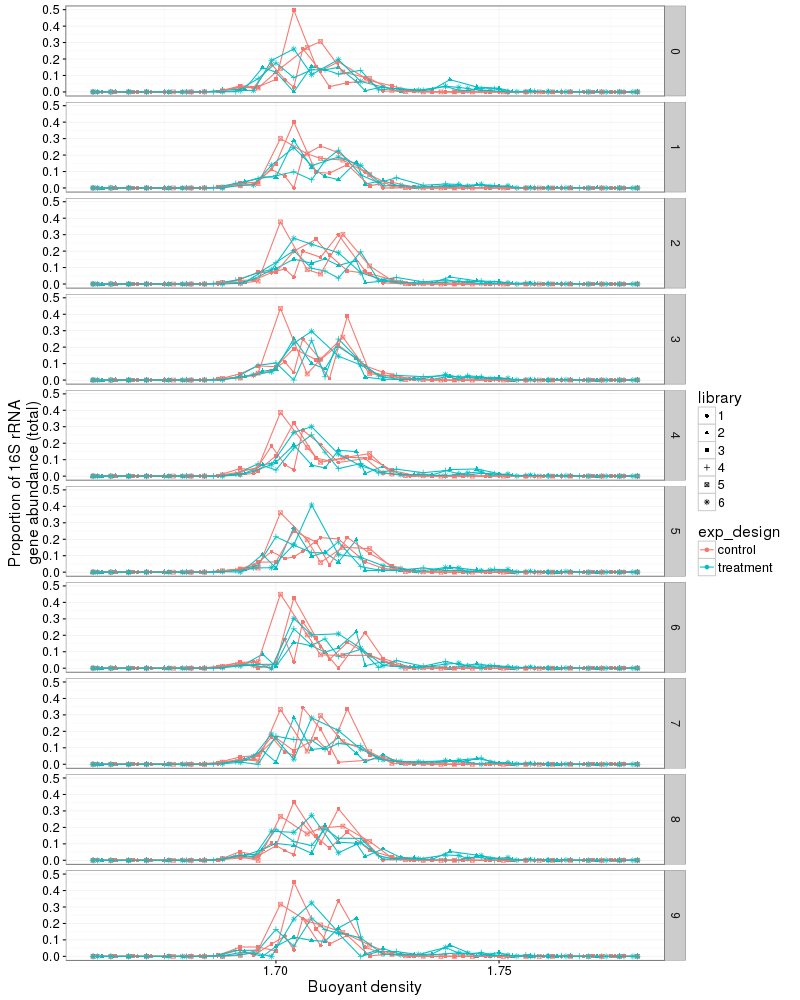

In [408]:
%%R -w 800 -h 1000

df = df %>%
    group_by(file, library) %>%
    mutate(frac_total_qPCR_copies = total_qPCR_copies / sum(total_qPCR_copies)) %>%
    ungroup() 

ggplot(df, aes(BD_mid, frac_total_qPCR_copies, color=exp_design, group=library, shape=library)) +
    geom_point() +
    geom_line() +
    facet_grid(file ~ .) +
    labs(x = 'Buoyant density', y='Proportion of 16S rRNA\ngene abundance (total)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Plotting % atom excess

In [409]:
qPCR_files = !find $buildDir -maxdepth 3 -name "OTU_abs1e9_PCR_sub_qSIP_atom.txt"
qPCR_files

['/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/7/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/0/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/9/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/8/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/3/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/2/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/1/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/4/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/5/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_

In [410]:
%%R -i qPCR_files
# loading files

df.atom = list()
for (x in qPCR_files){
    f = gsub('/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/([0-9.]+)/.+', '\\1', x)
    df.atom[[f]] = read.delim(x, sep='\t') 
    }
df.atom = do.call('rbind', df.atom)
df.atom$file = gsub('\\.[0-9]+$', '', rownames(df.atom))
rownames(df.atom) = 1:nrow(df.atom)
df.atom %>% head(n=3)

                                 taxon  control treatment       BD_diff
1       Acaryochloris_marina_MBIC11017 1.732038  1.712620 -1.941812e-02
2 Acetobacter_pasteurianus_IFO_3283-03 1.660658  1.660695  3.694927e-05
3       Acetobacterium_woodii_DSM_1030 1.737694  1.712298 -2.539593e-02
   control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1 0.735085930   308.0556         317.6636     304.6019        -0.3554633454
2 0.006711269   307.6943         317.6655     307.7012         0.0006789597
3 0.792799767   308.0842         317.6634     303.5817        -0.4648138948
  atom_CI_low atom_CI_high file
1   -1.318320    -0.170451    7
2   -0.029027     0.031164    7
3   -1.288916    -0.433736    7


## density shift

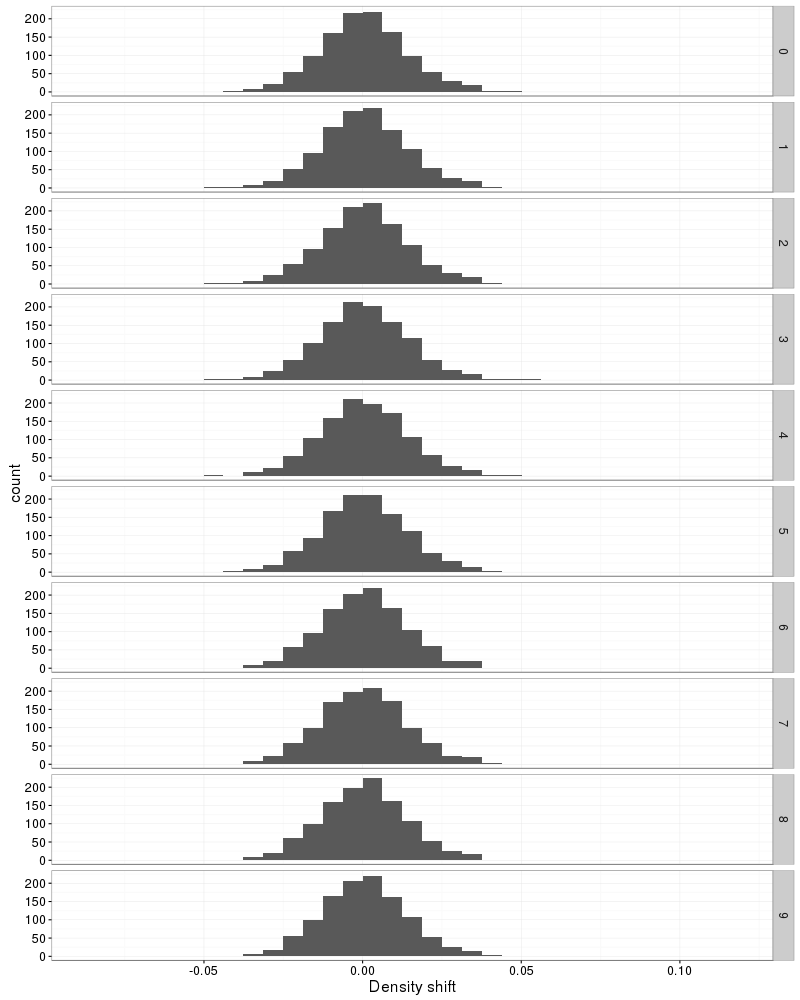

In [411]:
%%R -w 800 -h 1000

ggplot(df.atom, aes(BD_diff)) +
    geom_histogram() +
    labs(x='Density shift') +
    facet_grid(file ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Atom fraction excess

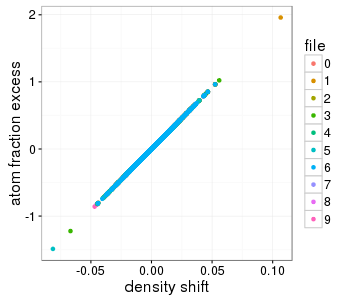

In [412]:
%%R -w 350 -h 300

ggplot(df.atom, aes(BD_diff, atom_fraction_excess, color=file)) +
    geom_point() +
    labs(x='density shift', y='atom fraction excess') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [413]:
%%R
ret = lm(atom_fraction_excess ~ BD_diff, data=df.atom)
print(ret)
summary(ret)


Call:
lm(formula = atom_fraction_excess ~ BD_diff, data = df.atom)

Coefficients:
(Intercept)      BD_diff  
  6.720e-05    1.832e+01  


Call:
lm(formula = atom_fraction_excess ~ BD_diff, data = df.atom)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0005648 -0.0000671 -0.0000426  0.0000229  0.0065560 

Coefficients:
             Estimate Std. Error   t value Pr(>|t|)    
(Intercept) 6.720e-05  1.295e-06     51.88   <2e-16 ***
BD_diff     1.832e+01  9.404e-05 194765.17   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0001385 on 11450 degrees of freedom
  (18 observations deleted due to missingness)
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 3.793e+10 on 1 and 11450 DF,  p-value: < 2.2e-16



In [414]:
%%R -w 800 -h 1200

df.atom = df.atom %>%
    mutate(incorporator = ifelse(atom_CI_low > 0, TRUE, FALSE)) %>%
    group_by(taxon) %>%
    mutate(median_atom_frac = median(atom_fraction_excess, na.rm=TRUE)) %>%
    ungroup()

df.atom$taxon = reorder(df.atom$taxon, -df.atom$median_atom_frac)


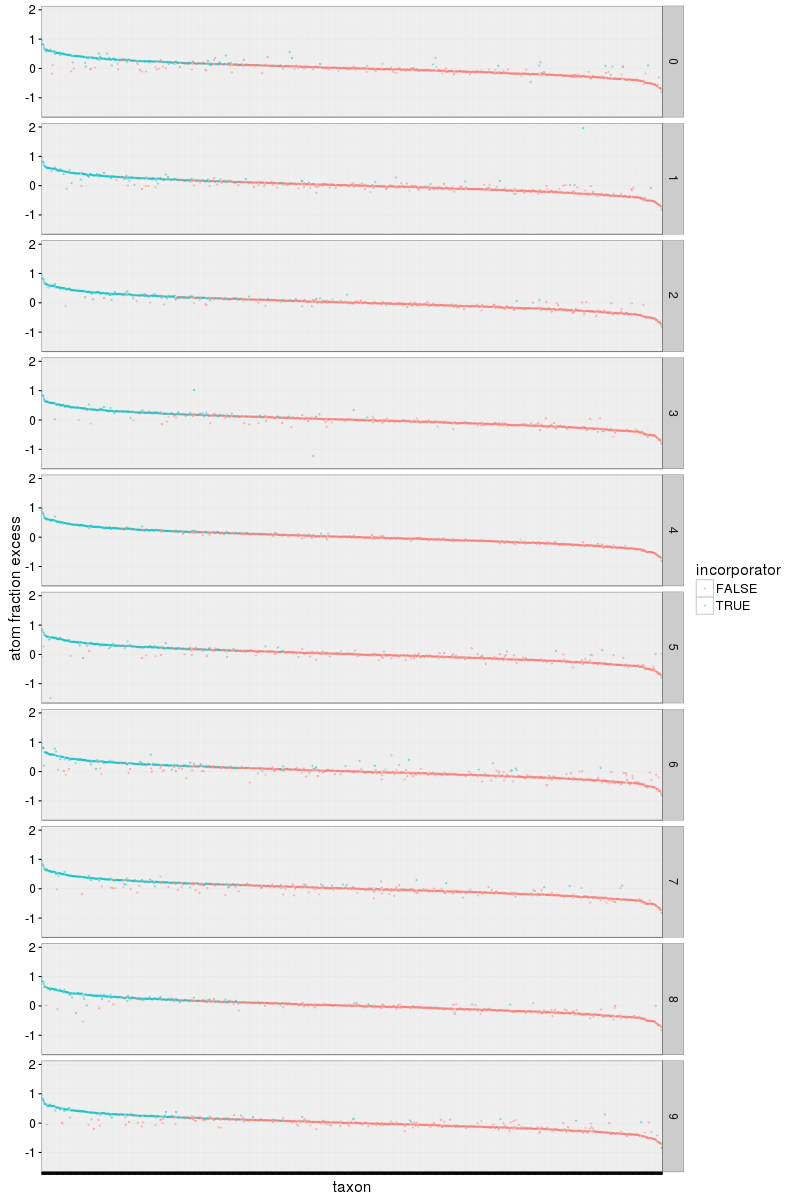

In [415]:
%%R -w 800 -h 1200
ggplot(df.atom, aes(taxon, atom_fraction_excess, color=incorporator)) +
    geom_point(alpha=0.3, size=0.5) +
    labs(y = 'atom fraction excess') +
    facet_grid(file ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
    )

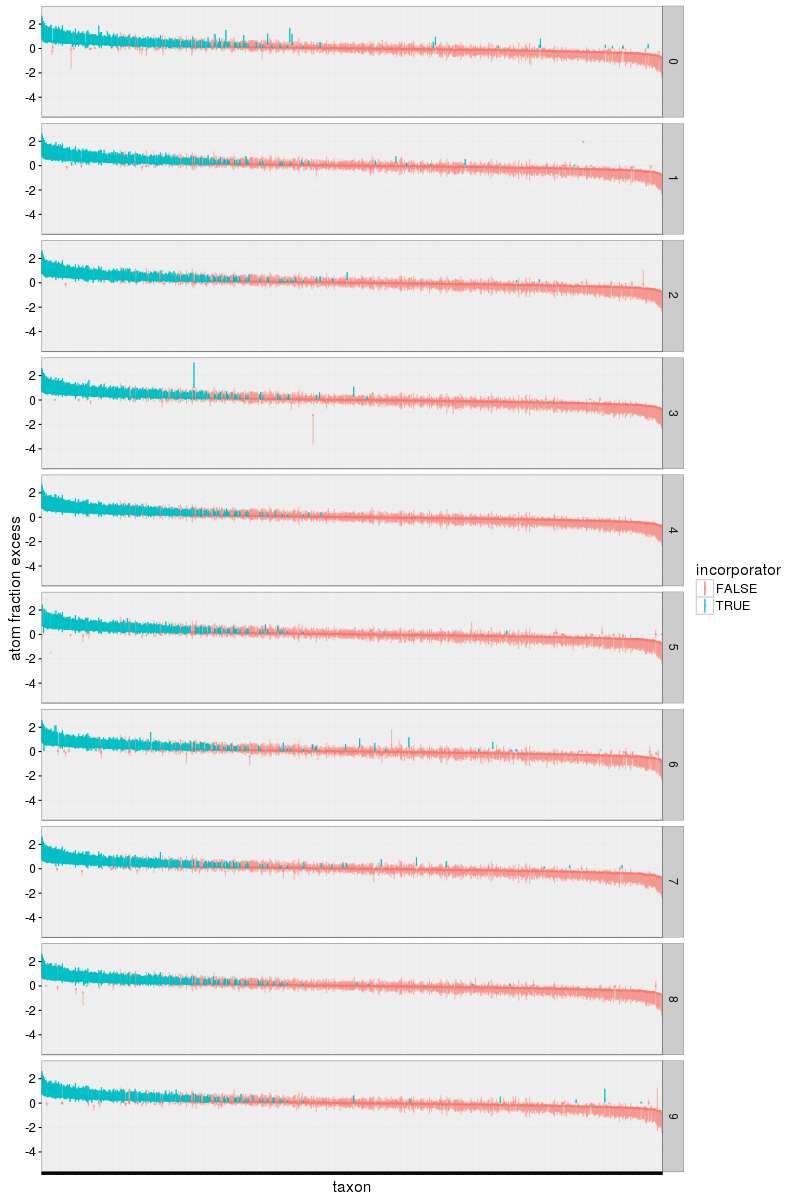

In [416]:
%%R -w 800 -h 1200
ggplot(df.atom, aes(taxon, atom_fraction_excess, color=incorporator,
                    ymin=atom_CI_low, ymax=atom_CI_high)) +
    geom_point(alpha=0.3, size=0.5) +
    geom_linerange(alpha=0.5) +
    geom_linerange(data=df.atom %>% filter(incorporator==TRUE)) +
    labs(y = 'atom fraction excess') +
    facet_grid(file ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
    )

### Just incorporators

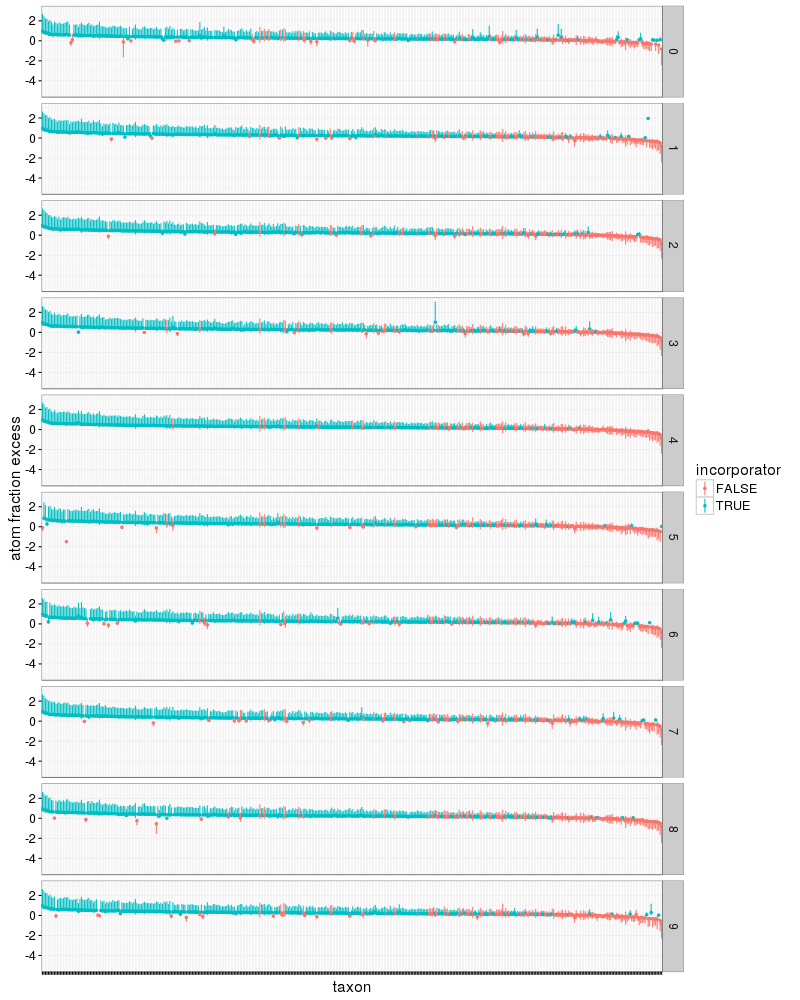

In [417]:
%%R -w 800 -h 1000

df.atom.inc = df.atom %>%
    mutate(incorporator = ifelse(atom_CI_low > 0, TRUE, FALSE)) %>%
    group_by(taxon) %>%
    mutate(incorporator_any = any(incorporator)) %>%
    filter(incorporator_any == TRUE) %>%
    group_by(taxon) %>%
    mutate(median_atom_frac = median(atom_fraction_excess, na.rm=TRUE)) %>%
    ungroup()

df.atom.inc$taxon = reorder(df.atom.inc$taxon, -df.atom.inc$median_atom_frac)

ggplot(df.atom.inc, aes(taxon, atom_fraction_excess, color=incorporator,
                    ymin=atom_CI_low, ymax=atom_CI_high)) +
    geom_point(size=1) +
    geom_linerange() +
    labs(y = 'atom fraction excess') +
    facet_grid(file ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
    )

### Summarizing number of incorporators

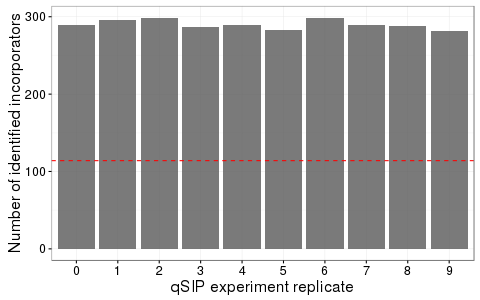

In [419]:
%%R -h 300
df.atom.s = df.atom %>%
    group_by(file) %>%
    summarize(n_incorp = sum(incorporator, na.rm=TRUE))

ggplot(df.atom.s, aes(file, n_incorp)) +
    geom_bar(stat='identity', alpha=0.8) +
    geom_hline(yintercept=114, linetype='dashed', color='red') +
    labs(x='qSIP experiment replicate', y='Number of identified incorporators') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Note

* Dashed red line is the expected % incorporators based on the simulation parameters

# Comparing BD shift between qSIP and known

`SIPSim BD_shift` **vs** `SIPSim qSIP_atomExcess`

### --Sandbox--

* Method
 * load BD-shift file
 * load atom_excess file (with CIs)
 * BD-shift incorporator cutoff:
   * 'BD_shift' > 0.05
 * atom_excess incorporator cutoff:
   * 'atom_CI_low' > 0

In [454]:
tmpDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/0/'
exe = '/home/nick/notebook/SIPSim/lib/R/qSIP_confuseMtx.r'
!cd $tmpDir; \
    $exe ../ampFrags_KDE_dif_DBL_inc_BD-shift.pkl OTU_abs1e9_PCR_sub_qSIP_atom.txt ../../exp_design.txt

File written: qSIP-cMtx_data.csv
File written: qSIP-cMtx
File written: qSIP-cMtx_table.csv
File written: qSIP-cMtx_overall.csv
File written: qSIP-cMtx_byClass.csv


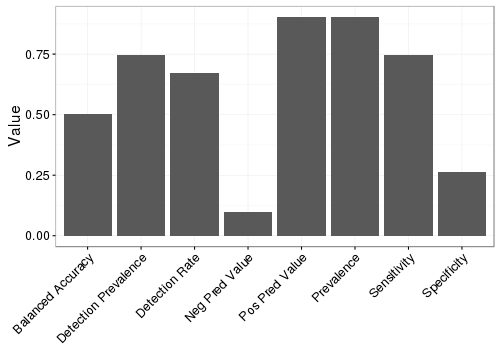

In [457]:
%%R -i tmpDir -w 500 -h 350

F = file.path(tmpDir, 'qSIP-cMtx_byClass.csv')
byClass = read.csv(F)

ggplot(byClass, aes(X, byClass)) +
    geom_bar(stat='identity') +
    labs(y='Value') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [367]:
%%R
library(caret)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [431]:
%%R
atomFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/0/OTU_abs1e9_PCR_sub_qSIP_atom.txt'
BDshiftFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/ampFrags_KDE_dif_DBL_inc_BD-shift.pkl'
BD_shift_cutoff = 0.05

In [421]:
%%R 
df.atom = read.delim(atomFile, sep='\t')
df.shift = read.delim(BDshiftFile, sep='\t')

df.atom %>% head(n=3) %>% as.data.frame %>% print
print('-----------')
df.shift %>% head(n=3) %>% as.data.frame %>% print

                                 taxon  control treatment     BD_diff
1       Acaryochloris_marina_MBIC11017 1.732038  1.712617 -0.01942096
2 Acetobacter_pasteurianus_IFO_3283-03 1.718243  1.722567  0.00432446
3       Acetobacterium_woodii_DSM_1030 1.730174  1.712039 -0.01813467
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7350809   308.0556         317.6636     304.6014          -0.35551518
2  0.5943161   307.9858         317.6639     308.7609           0.07920126
3  0.7160570   308.0462         317.6636     304.8174          -0.33198845
  atom_CI_low atom_CI_high
1   -1.220665    -0.299530
2   -0.146502     0.428335
3   -0.965131    -0.284687
[1] "-----------"
  lib1 lib2                         taxon BD_shift
1   NA    1 Tropheryma_whipplei_str_Twist        0
2   NA    1   Caldisericum_exile_AZM16c01      NaN
3   NA    1 Sorangium_cellulosum_So0157-2        0


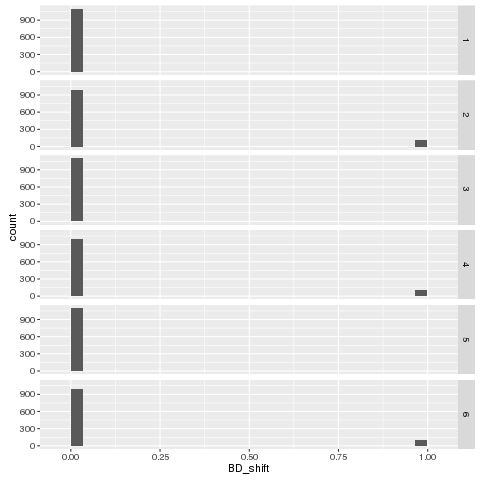

In [422]:
%%R
ggplot(df.shift, aes(BD_shift)) +
    geom_histogram() +
    facet_grid(lib2 ~ .)

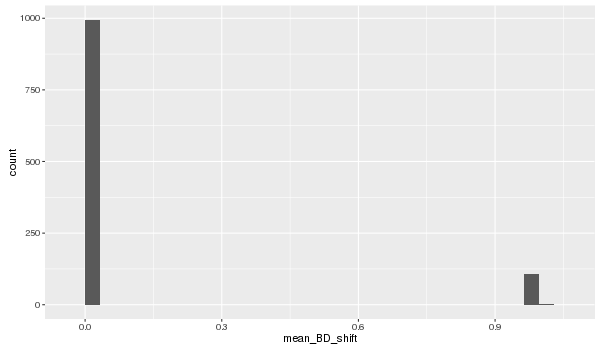

In [427]:
%%R -w 600 -h 350
# summarizing BD shift for treatments
treatments = c(2,4,6)
df.shift.s = df.shift %>%
    filter(lib2 %in% treatments) %>%
    group_by(taxon) %>%
    summarize(mean_BD_shift = mean(BD_shift, na.rm=TRUE))

ggplot(df.shift.s, aes(mean_BD_shift)) +
    geom_histogram()

#df.shift.s %>% head

In [429]:
%%R
# joining
df.j = inner_join(df.atom, df.shift.s, c('taxon' = 'taxon'))

df.atom %>% nrow %>% print
df.shift.s %>% nrow %>% print
df.j %>% nrow %>% print
df.j %>% head(n=4)

[1] 1147
[1] 1147
[1] 1147
                                 taxon  control treatment     BD_diff
1       Acaryochloris_marina_MBIC11017 1.732038  1.712617 -0.01942096
2 Acetobacter_pasteurianus_IFO_3283-03 1.718243  1.722567  0.00432446
3       Acetobacterium_woodii_DSM_1030 1.730174  1.712039 -0.01813467
4    Acetohalobium_arabaticum_DSM_5501 1.710775  1.727909  0.01713429
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7350809   308.0556         317.6636     304.6014          -0.35551518
2  0.5943161   307.9858         317.6639     308.7609           0.07920126
3  0.7160570   308.0462         317.6636     304.8174          -0.33198845
4  0.5181079   307.9480         317.6642     311.0322           0.31390815
  atom_CI_low atom_CI_high mean_BD_shift
1   -1.220665    -0.299530             0
2   -0.146502     0.428335             0
3   -0.965131    -0.284687             0
4    0.291575     0.926449             0


In [433]:
%%R
# identifying incorporators
df.j = df.j %>%
    mutate(qSIP_incorper = ifelse(atom_CI_low > 0, TRUE, FALSE),
           hrSIP_incorper = ifelse(mean_BD_shift > BD_shift_cutoff, TRUE, FALSE))
df.j %>% head(n=3)           

                                 taxon  control treatment     BD_diff
1       Acaryochloris_marina_MBIC11017 1.732038  1.712617 -0.01942096
2 Acetobacter_pasteurianus_IFO_3283-03 1.718243  1.722567  0.00432446
3       Acetobacterium_woodii_DSM_1030 1.730174  1.712039 -0.01813467
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7350809   308.0556         317.6636     304.6014          -0.35551518
2  0.5943161   307.9858         317.6639     308.7609           0.07920126
3  0.7160570   308.0462         317.6636     304.8174          -0.33198845
  atom_CI_low atom_CI_high mean_BD_shift qSIP_incorper hrSIP_incorper
1   -1.220665    -0.299530             0         FALSE          FALSE
2   -0.146502     0.428335             0         FALSE          FALSE
3   -0.965131    -0.284687             0         FALSE          FALSE


In [435]:
%%R
cf.mtx = confusionMatrix(df.j$qSIP_incorper, df.j$hrSIP_incorper)
cf.mtx

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE   741   79
     TRUE    252   28
                                         
               Accuracy : 0.6991         
                 95% CI : (0.671, 0.7261)
    No Information Rate : 0.9027         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.0046         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.7462         
            Specificity : 0.2617         
         Pos Pred Value : 0.9037         
         Neg Pred Value : 0.1000         
             Prevalence : 0.9027         
         Detection Rate : 0.6736         
   Detection Prevalence : 0.7455         
      Balanced Accuracy : 0.5040         
                                         
       'Positive' Class : FALSE          
                                         


In [437]:
%%R
names(cf.mtx)

[1] "positive" "table"    "overall"  "byClass"  "dots"    


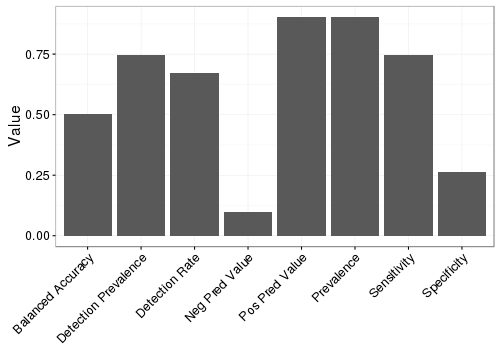

In [452]:
%%R -w 500 -h 350
cf.mtx.df = cf.mtx$byClass %>% as.data.frame 
colnames(cf.mtx.df) = c('Value')
cf.mtx.df$Measure = rownames(cf.mtx.df)

ggplot(cf.mtx.df, aes(Measure, Value)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )

#### Notes:

* Very low sensitivity & specificity for qSIP data
  * at least, for these settings

# DEBUG: Calculate atom excess from BD shift

In [254]:
# reference: Hungate et al., 2015. AEM
W_light = 1.7
W_heavy = 1.7 + 0.02

def GC_content(W_light):
    G = 1/0.083506 * (W_light - 1.646057)
    return G

def G2M_light(G):
    M_light = 0.496 * G + 307.691
    return M_light

def M_light2M_heavyMax(G, M_light):   # 13C
    M_heavyMax = -0.4987282 * G + 9.974564 + M_light
    return M_heavyMax

def calc_M_lab(Z, W_light, M_light):
    M_lab = (Z / W_light + 1) * M_light
    return M_lab

def calc_atom_excess(M_lab, M_light, M_heavyMax):
    x = M_lab - M_light
    y = M_heavyMax - M_light
    A_carbon = x / y * (1-0.01111233)
    return A_carbon

def W2atomFrac(W_light, W_heavy):
    Z = W_heavy - W_light
    G = GC_content(W_light)
    M_light = G2M_light(G)
    M_heavyMax = M_light2M_heavyMax(G, M_light)
    M_lab = calc_M_lab(Z, W_light, M_light)
    atomX = calc_atom_excess(M_lab, M_light, M_heavyMax)
    return atomX


# run
W2atomFrac(W_light, W_heavy)

0.371244191475315